# Case 3 - Water Table Estimation & Well Optimization
Welcome to the demonstration notebook where we'll spatially estimate the groundwater table and then go over an example for well optimization to select a subset of wells to capture the spatiotemporal variability of groundwater table using the **pylenm** package!<br>
Let’s get started!

## Setup
Make sure to install pylenm from https://pypi.org/project/pylenm/ by running `pip install pylenm_` in your environment terminal. Once completed, you should be able to import the package. Note: to update to the latest version of pylenm run: `pip install pylenm --upgrade`

#### Sidenote regarding `richdem` installation

This works only for python <= 3.10.
It does have a GDAL dependency. So if GDAL is not installed, do the following:
```
> pip install GDAL
> pip install --upgrade richdem
```

In [43]:
# pip install pylenm
# pip install pyproj
# pip install rasterio
# pip install elevation
# pip install richdem       # this only works for python <= 3.10

In [44]:
# Basics
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import  MinMaxScaler
from sklearn.model_selection import LeaveOneOut
from math import sqrt
from sklearn.metrics import r2_score

# # pylenm
# import pylenm
# print("pylenm version: ", pylenm.__version__)
# from pylenm import PylenmDataFactory

# pylenm2
import pylenm2
print("pylenm version: ", pylenm2.__version__)
from pylenm2 import PylenmDataModule

# GIS data layers
from pyproj import Transformer, CRS
import rasterio
# import elevation
import richdem as rd

plt.rcParams["font.family"] = "Times New Roman"


# To avoid large warning prints
WARNING_MESSAGES_TO_IGNORE = [
    ".*the bound and calling fit again may find a better value.*",
    ".*lbfgs failed to converge.*",
    ".*Objective did not converge. You might want to increase the number of iterations.*",
    ".*R^2 score is not well-defined with less than two samples.*",
]

pylenm version:  2.7.1


## GIS Data Layers

In [45]:
# Load GIS elevation data
# UNCOMMENT THE 2 LINES BELOW IF YOU DO NOT HAVE THE DEM FILE ALREADY
# dem_path = os.path.join(os.getcwd(), 'FArea-30m-DEM_cropped.tif')
# elevation.clip(bounds=(-81.6855, 33.2657, -81.6734, 33.2785), output=dem_path)

# IF YOU DO HAVE THE DEM FILE ALREADY
# dem_path = "./data/FArea-30m-DEM_cropped.tif"
dem_path = "https://github.com/ALTEMIS-DOE/pylenm/raw/refs/heads/satyarth/notebooks2/data/FArea-30m-DEM_cropped.tif"

farea_dem = rd.LoadGDAL(dem_path)
farea_ras = rasterio.open(dem_path)

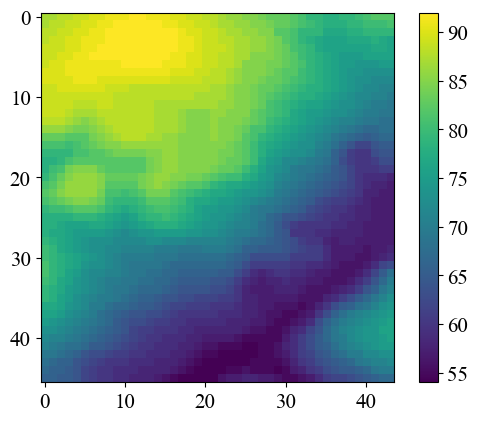

In [46]:
plt.imshow(farea_dem, interpolation='none')
plt.colorbar()
plt.show()

In [47]:
crs = CRS.from_epsg("26917")
proj = Transformer.from_crs(crs.geodetic_crs, crs)

x_loc = np.zeros([farea_ras.height, farea_ras.width])
y_loc = np.zeros([farea_ras.height, farea_ras.width])
for i in range(farea_ras.height):
  for j in range(farea_ras.width):
    lon = farea_ras.xy(i,j)[0]
    lat = farea_ras.xy(i,j)[1]
    utm_x, utm_y =proj.transform(lat,lon) # Latitude/Longitude to UTM
    x_loc[i,j] = utm_x
    y_loc[i,j] = utm_y

In [48]:
slope = rd.TerrainAttribute(farea_dem, attrib='slope_riserun')
accum = rd.FlowAccumulation(farea_dem, method='D8')
twi   = np.log(accum/slope)


A/var/folders/4f/fztycq7j0wj0t_2bhzck543c0000gp/T/ipykernel_46666/3896729822.py:3: RuntimeWarning: divide by zero encountered in divide
  twi   = np.log(accum/slope)
 Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000973208===================  ] (97% - 0.0s - 1 threads)

A O'Callaghan (1984)/Marks (1984) D8/D4 Flow Accumulation
C O'Callaghan, J.F., Mark, D.M., 1984. The Extraction of Drainage Networks from Digital Elevation Data. Computer vision, graphics, and image processing 28, 323--344.

c topology = D8
[================================================= ] (99% - 0.0s - 1 threads)==========              ] (72% - 0.0s - 1 threads)
A Generic Flow Accumulation Algorithm
p Creating dependencies array...

d Source cells found = 830
p Calculating flow accumulation...
t Wall-time       = 0.000944375 s============ ] (99% - 0.0s - 1 threads)


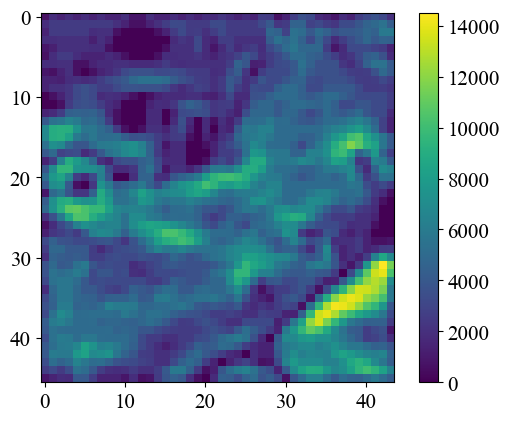

In [49]:
plt.imshow(slope, interpolation='none')
plt.colorbar()
plt.show()

## Load Well Time Series Data + Preprocess

In [50]:
from pylenm2.data import filters

# Load and process well time-series data
# url_1 = 'https://raw.githubusercontent.com/ALTEMIS-DOE/pylenm/master/notebooks/data/FASB_Data_thru_3Q2015_Reduced_Demo.csv'
# url_2 = 'https://github.com/ALTEMIS-DOE/pylenm/blob/master/notebooks/data/FASB%20Well%20Construction%20Info.xlsx?raw=true'

# url_1 = './data/FASB_Data_thru_3Q2015_Reduced_Demo.csv'
# url_2 = './data/FASB Well Construction Info.xlsx'

url_1 = "https://raw.githubusercontent.com/ALTEMIS-DOE/pylenm/refs/heads/satyarth/notebooks2/data/FASB_Data_thru_3Q2015_Reduced_Demo_general.csv"
url_2 = "https://github.com/ALTEMIS-DOE/pylenm/raw/refs/heads/satyarth/notebooks2/data/FASB_Well_Construction_Info_general.xlsx?raw=true"

concentration_data = pd.read_csv(url_1, dtype={15: str, 22: str, 23: str})
construction_data = pd.read_excel(url_2, engine='openpyxl')
# pylenm_df = PylenmDataFactory(concentration_data)
# pylenm_df.simplify_data(inplace=True)
pylenm2_dm = PylenmDataModule(data=concentration_data)
filters.simplify_data(data=pylenm2_dm, inplace=True)
pylenm2_dm.set_construction_data(construction_data)

Successfully imported the data!



Data summary for water table

In [51]:
from pylenm2.data import fetchers

# WT_details = pylenm_df.get_analyte_details('DEPTH_TO_WATER')
WT_details = fetchers.get_analyte_details(
    data_pylenm_dm=pylenm2_dm,
    analyte_name='DEPTH_TO_WATER',
)
WT_details

,Start Date,End Date,Date Range (days),Unique samples
Station Name,,,,
FSB 94D,1990-01-01,1990-10-08,280,4
FSB 95D,1990-01-01,1990-10-08,280,4
FSB 77,1990-01-01,2006-10-16,6132,122
FSB111C,1990-01-01,2006-10-17,6133,115
FSB105C,1990-01-01,2006-10-19,6135,127
...,...,...,...,...
FSB146D,2015-04-29,2015-09-09,133,9
FSB145D,2015-04-30,2015-09-09,132,9
FSB143D,2015-05-04,2015-09-09,128,9


Select wells that have enough and recent samples

In [52]:
n_samples = WT_details['Unique samples']
end_date = WT_details['End Date']
start_date = WT_details['Start Date']
station_names = WT_details.index
station_enough = station_names[n_samples>20]

station_recent = station_names[end_date > datetime.strptime('2015-01-01', '%Y-%m-%d').date()]
station_old = station_names[start_date < datetime.strptime('2006-01-01', '%Y-%m-%d').date()]

Temporal interpolation of the time series at equal frequency

In [53]:
from pylenm2.data import transformation

# wt_interp = pylenm_df.interpolate_wells_by_analyte('DEPTH_TO_WATER', frequency='1M', rm_outliers=True, z_threshold=3)
wt_interp = transformation.interpolate_stations_by_analyte(
    data_pylenm_dm=pylenm2_dm,
    analyte='DEPTH_TO_WATER', 
    frequency='1M', 
    rm_outliers=True, 
    z_threshold=3,
)

Select the upper aquifer wells and the wells that have enough samples

52 stations


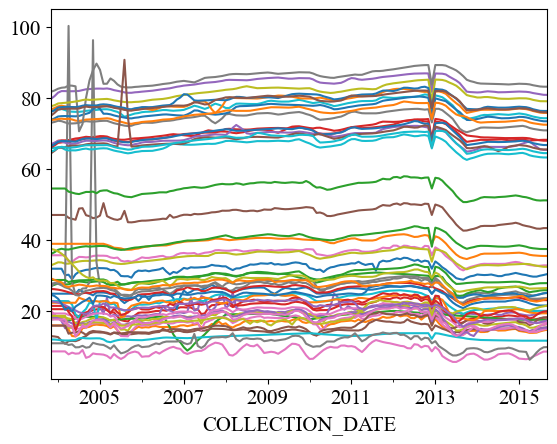

In [54]:
# active = list(np.unique(pylenm_df.filter_by_column(pylenm_df.get_Construction_Data(), col='WELL_USE', equals=['ACTIVE']).index))
active = list(np.unique(filters.filter_by_column(
    pylenm2_dm.get_construction_data(), 
    col='STATION_USE', 
    equals=['ACTIVE'],
).index))

# upper_wells = list(np.unique(pylenm_df.filter_by_column(pylenm_df.get_Construction_Data(), col='AQUIFER', equals=['UAZ_UTRAU']).index))
upper_stations = list(np.unique(filters.filter_by_column(
    pylenm2_dm.get_construction_data(), 
    col='AQUIFER', 
    equals=['UAZ_UTRAU'],
).index))

station_only_D = list(set(upper_stations) & set(wt_interp.columns)& set(station_enough)& set(station_recent)& set(station_old) & set(active))
wt_interp = wt_interp[station_only_D]
wt_interp.plot(legend=False)
print(wt_interp.shape[1], "stations")

Let's remove the 'bad' time series wells

46 stations


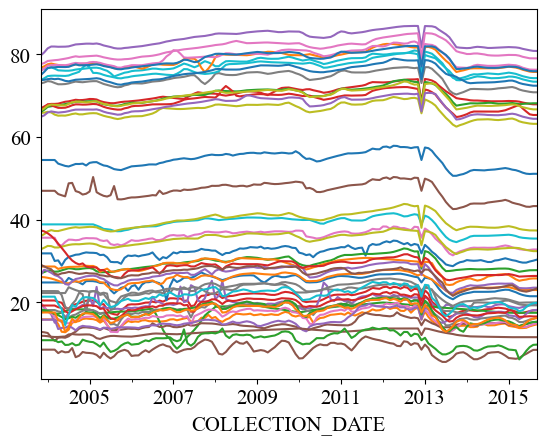

In [55]:
bad_ones = ['FSB108D', 'FSB131D', 'FSB 90D', 'FOB 13D', 'FBI 14D', 'FBI 17D']
# bad_ones = ['FSB108D', 'FSB131D', 'FSB 90D', 'FIB  1', 'FIB  8', 'FSB137D', 'FBI 17D', 'FSB 79']
wt_interp = wt_interp.drop(columns=bad_ones)
wt_interp.plot(legend=False)
print(wt_interp.shape[1], "stations")

In [56]:
# Reorder columns to be in alphabetical order
wt_interp = wt_interp.reindex(sorted(wt_interp.columns), axis=1)

# Convert to meters
wt_interp = wt_interp * 0.3048

<Axes: xlabel='COLLECTION_DATE'>

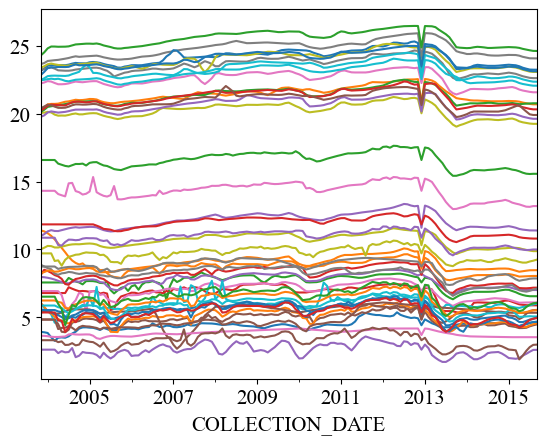

In [57]:
wt_interp.plot(legend=False)

## Well Location Data

In [58]:
station_info = pylenm2_dm.get_construction_data()

Match the well indecies between the time series and locations

In [59]:
shared_stations = list(set(station_info.index) & set(wt_interp.columns))
wt_interp = wt_interp[shared_stations]
# Reorder columns to be in alphabetical order
wt_interp = wt_interp.reindex(sorted(wt_interp.columns), axis=1)

station_info = station_info.T[shared_stations]
# Reorder columns to be in alphabetical order
station_info = station_info.reindex(sorted(station_info.columns), axis=1)
station_info = station_info.T

In [60]:
crs = CRS.from_epsg("26917")
proj = Transformer.from_crs(crs.geodetic_crs, crs)
UTM_x, UTM_y = proj.transform(station_info.LATITUDE,station_info.LONGITUDE)

Take out the ground-surface elevation, and compute the water table elevation

In [61]:
elev = station_info.REFERENCE_ELEVATION
elev.index = station_info.index
elev = elev.T
elev = elev * 0.3048 # convert to meters

# Now this is the water table elevation (GROUND_ELEVATION - DEPTH_TO_WATER)
wt_interp = elev.values - wt_interp

# Reorder columns to be in alphabetical order
wt_interp = wt_interp.reindex(sorted(wt_interp.columns), axis=1)

In [62]:
wt_interp = wt_interp.apply(pd.to_numeric, errors='coerce')
# wt_interp = np.log2(wt_interp)
wt_interp = np.log10(wt_interp)

In [63]:
# GETS APPROXIMATE WT VALUE IN THE XX GRID
def get_approx_predictions(X, y_map, XX):
    X_approx, y_approx = [],[]
    for i in range(X.shape[0]):
        x1, y1 = X.iloc[i].Easting, X.iloc[i].Northing # ACTUAL POINT

        abs_east = np.abs(XX.Easting-x1)
        abs_north= np.abs(XX.Northing-y1)

        c = np.maximum(abs_north,abs_east)
        index = np.argmin(c)
        XX.iloc[index].Easting, XX.iloc[index].Northing

        X_approx.append([
            XX.iloc[index].Easting, 
            XX.iloc[index].Northing, 
            XX.iloc[index].Elevation,
        ])
        y_approx.append(y_map[index])
    
    X_approx = pd.DataFrame(X_approx, columns=['Easting', 'Northing', 'Elevation'])
    
    return X_approx, y_approx

In [64]:
X = np.vstack((UTM_x,UTM_y, elev.values)).T
X = pd.DataFrame(X, columns=['Easting', 'Northing', 'Elevation'])

XX = np.vstack([
    x_loc.flatten(), 
    y_loc.flatten(), 
    farea_dem.flatten(), 
    slope.flatten(), 
    accum.flatten(),
]).T
XX = pd.DataFrame(XX, columns=['Easting', 'Northing', 'Elevation', 'Slope', 'Acc'])


X_approx, Slope_X = get_approx_predictions(X, slope.flatten(), XX)
X_approx, Acc_X = get_approx_predictions(X, accum.flatten(), XX)

X = np.vstack((UTM_x,UTM_y, elev.values, Slope_X, Acc_X)).T
X = pd.DataFrame(X, columns=['Easting', 'Northing', 'Elevation', 'Slope', 'Acc'])

In [65]:
print(X.shape)
X.head()

(46, 5)


,Easting,Northing,Elevation,Slope,Acc
0,436915.185626,3681526.011324,64.864488,3710.795166,1.0
1,436691.311919,3681466.821435,70.673976,5400.0,2.0
2,436815.34352,3681532.531246,69.872352,6644.17041,4.0
3,436842.110445,3681572.787131,69.238368,5130.789551,3.0
4,436664.132457,3681447.159625,69.7992,4970.412598,18.0


In [66]:
print(XX.shape)
XX.head()

(2024, 5)


,Easting,Northing,Elevation,Slope,Acc
0,436159.683552,3.682384e+06,87.0,636.396118,1.0
1,436185.551274,3.682384e+06,87.0,1909.188354,7.0
2,436211.418995,3.682384e+06,88.0,1423.024902,1.0
3,436237.286716,3.682384e+06,88.0,1909.188354,6.0
4,436263.154436,3.682383e+06,89.0,1423.024902,1.0


In [67]:
year = 2015
y = np.array(wt_interp.loc[wt_interp.index[pd.Series(wt_interp.index).dt.year == year]].mean())
print(y)
station_names = list(wt_interp.columns)

[1.78081145 1.79665138 1.80042567 1.80110491 1.79756071 1.79292218
 1.79563749 1.81641807 1.80413778 1.78263987 1.80783352 1.81479163
 1.81344268 1.81123607 1.809166   1.80639769 1.8060446  1.80541176
 1.80600684 1.80751179 1.80900951 1.79561396 1.81035935 1.79842038
 1.81571852 1.76550186 1.76618254 1.8012992  1.80737593 1.80137329
 1.79124787 1.80736828 1.80180301 1.80250098 1.7995847  1.77848138
 1.79698336 1.78371805 1.79530093 1.79680089 1.79468336 1.79667774
 1.79201348 1.79135187 1.77620335 1.79041793]


In [68]:
from pylenm2.stats import gp as stats_gp

import warnings
for msg in WARNING_MESSAGES_TO_IGNORE:
    warnings.filterwarnings(
        "ignore", 
        message=msg,
    )


y_map, r_map, residuals, lr_trend = stats_gp.interpolate_topo(
    X, 
    y, 
    XX, 
    ft=['Elevation'], 
    regression='linear', 
    smooth=True,
)

/var/folders/4f/fztycq7j0wj0t_2bhzck543c0000gp/T/ipykernel_46666/3883794830.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


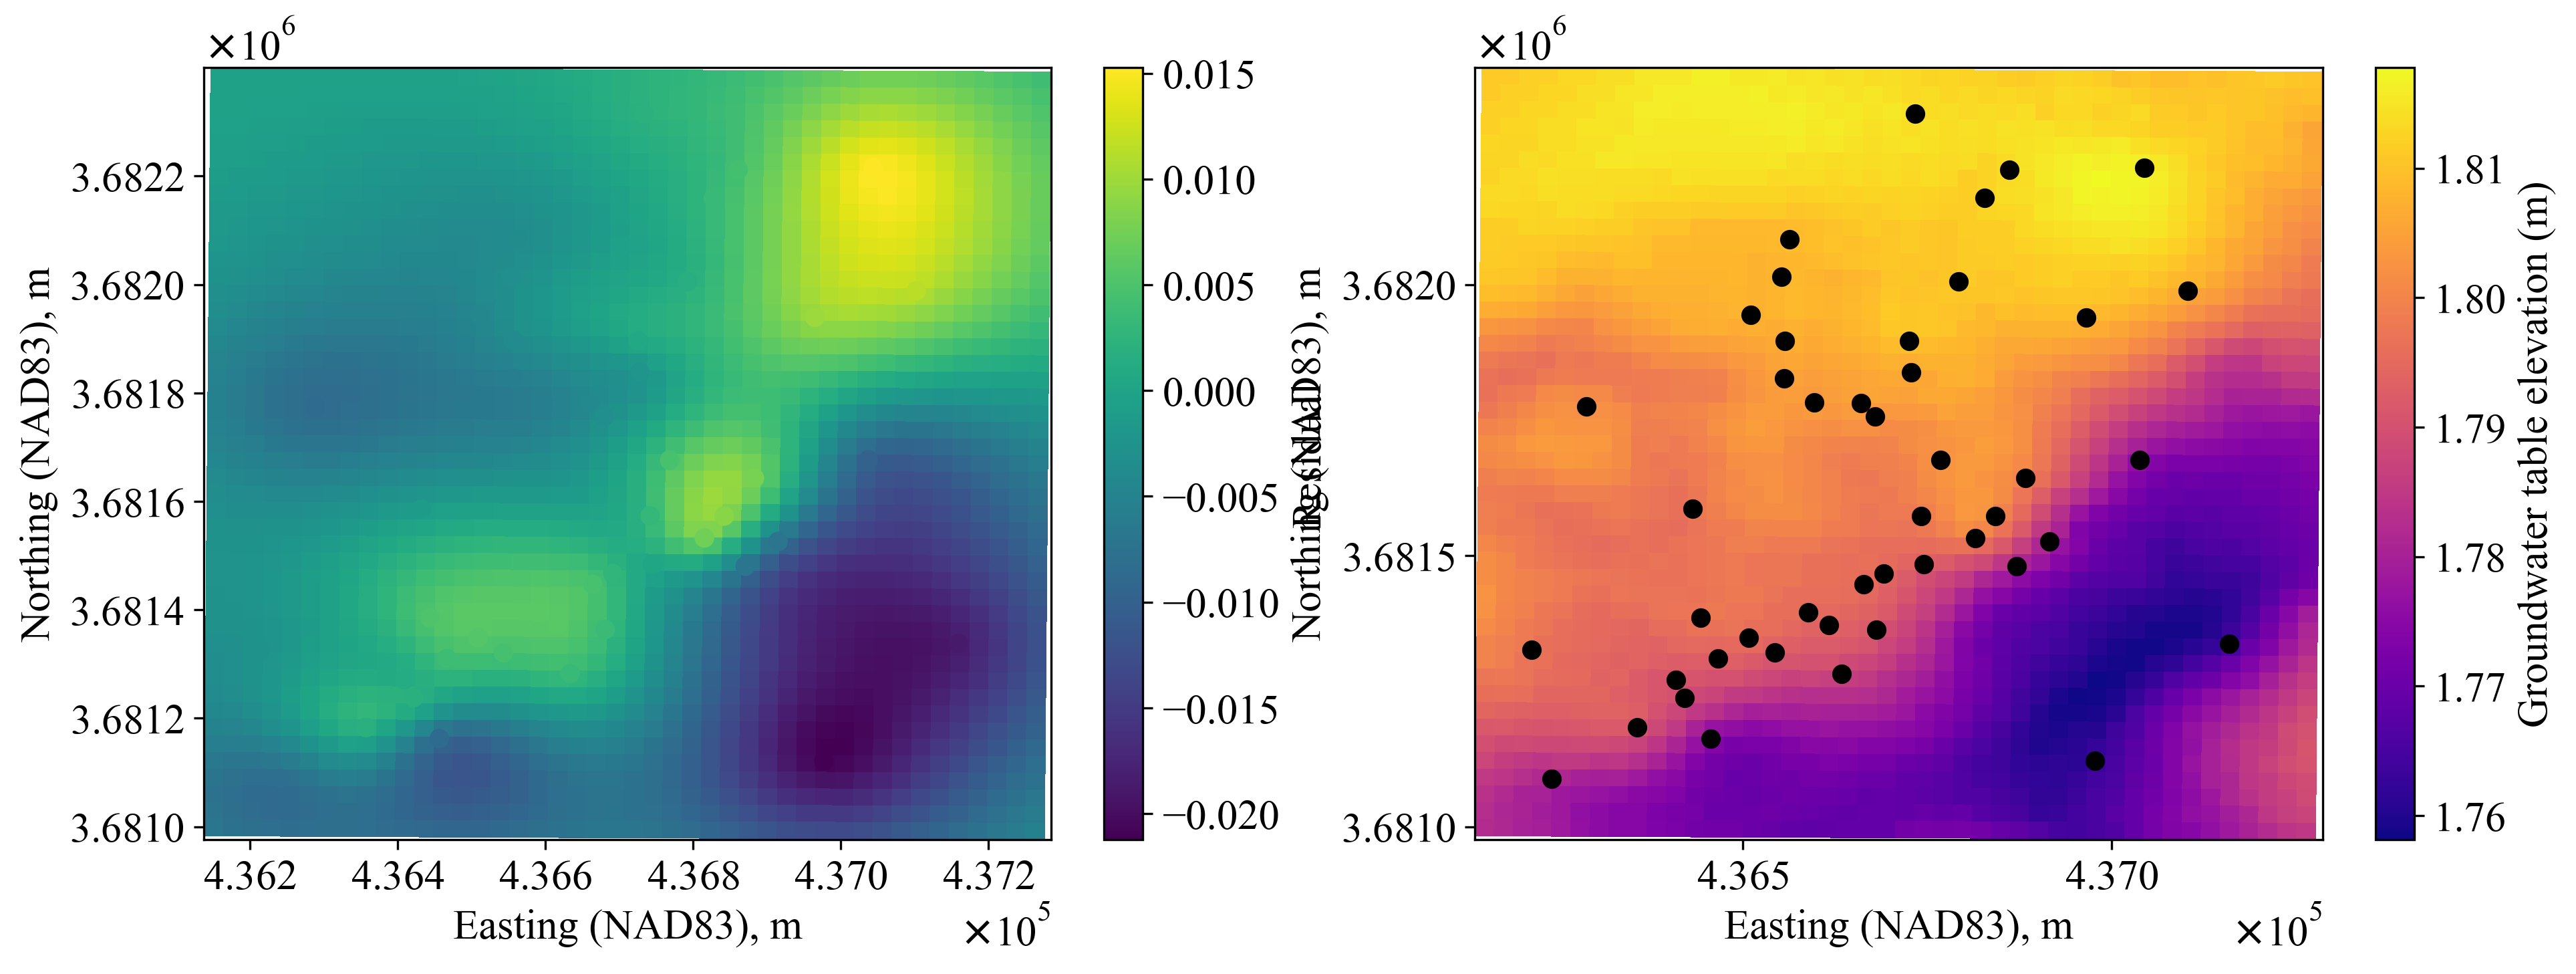

In [69]:
# Plot all result details
fontsize = 15

fig, ax = plt.subplots(1,2, figsize=(15,5), dpi=300)

xx = np.array(XX)
plt.locator_params(axis='both', nbins=4, tight=False)

titles = ["Kriging map colored by residuals from\n Regression trend line", str("Linear Regression + Kriging\n Water table Reference Field | {}".format("Averaged 2005"))]

map_0 = ax[0].pcolor(
    xx[:,0].reshape(x_loc.shape),
    xx[:,1].reshape(x_loc.shape),
    r_map.reshape(x_loc.shape),
)
fig.colorbar(map_0, ax=ax[0]).set_label(label='Residual',size=fontsize)

map_1 = ax[1].pcolor(
    xx[:,0].reshape(x_loc.shape),
    xx[:,1].reshape(x_loc.shape),
    y_map.reshape(x_loc.shape), 
    cmap='plasma',
)
fig.colorbar(map_1, ax=ax[1]).set_label(label='Groundwater table elevation (m)',size=fontsize)

colors=[residuals, 'black']

for i in range(2):
    ax[i].scatter(X.iloc[:,0], X.iloc[:,1], c=colors[i], alpha=1)
    # ax[i].set_xticks(fontsize=fontsize)
    ax[i].tick_params(axis='both', which='major', labelsize=fontsize)
    # ax[i].yticks(fontsize=fontsize)
    ax[i].set_xlabel("Easting (NAD83), m", fontsize=fontsize)
    ax[i].set_ylabel("Northing (NAD83), m", fontsize=fontsize)
    # ax[i].set_title(titles[i],y=1.04, fontweight='bold')
    ax[i].ticklabel_format(style='sci', axis='both',scilimits=(-1,1), useMathText=True)

fig.show()

In [70]:
from tqdm import tqdm

from pylenm2.stats import metrics

import warnings
for msg in WARNING_MESSAGES_TO_IGNORE:
    warnings.filterwarnings(
        "ignore", 
        message=msg,
    )

pd.set_option('max_colwidth', 100)

# TEST ALL - Regular Fitting Process
model_results = pd.DataFrame(columns=['model', 'features', 'mse', 'r2'])

# Save GP results 
gp, y_map_gp = stats_gp.fit_gp(
    X=X[['Easting', 'Northing']], 
    y=y, 
    xx=XX[['Easting', 'Northing']],
)
X_approx, y_approx = get_approx_predictions(X, y_map_gp, XX)
model_results.loc[len(model_results.index)] = [
    "GP", 
    np.NaN, 
    metrics.mse(y, y_approx), 
    r2_score(y, y_approx),
]

feature_params = [
    ['Elevation'], 
    ['Elevation', 'Slope'], 
    ['Easting', 'Northing'], 
    ['Easting', 'Northing', 'Elevation'], 
    ['Easting', 'Northing', 'Elevation', 'Slope'], 
    ['Easting', 'Northing', 'Elevation', 'Slope', 'Acc'],
]

# Save Results for our approach  
for ft in tqdm(feature_params, desc="Feature params"):
    y_map_lr, r_map_lr, residuals_lr, lr_trend = stats_gp.interpolate_topo(X, y, XX, ft=ft, regression='linear', smooth=True)
    y_map_rf, r_map_rf, residuals_rf, rf_trend = stats_gp.interpolate_topo(X, y, XX, ft=ft, regression='rf', smooth=True)
    y_map_rid, r_map_rid, residual_rid, rid_trend = stats_gp.interpolate_topo(X, y, XX, ft=ft, regression='ridge', smooth=True)
    y_map_las, r_map_las, residuals_las, las_trend = stats_gp.interpolate_topo(X, y, XX, ft=ft, regression='lasso', smooth=True)

    y_maps = [y_map_lr, y_map_rf, y_map_rid, y_map_las]
    model_names = ["Linear", "Random Forest", "Ridge", "Lasso"]
    for y_map, model_name in zip(y_maps, model_names):
        X_approx, y_approx = get_approx_predictions(X, y_map, XX)
        model_results.loc[len(model_results.index)] = [model_name, ft, metrics.mse(y, y_approx), r2_score(y, y_approx)]

Feature params: 100%|██████████| 6/6 [00:27<00:00,  4.58s/it]


In [71]:
model_results.sort_values(by='r2', ascending=False)

,model,features,mse,r2
10,Random Forest,"[Easting, Northing]",2.338865e-07,0.998313
20,Lasso,"[Easting, Northing, Elevation, Slope]",2.690658e-07,0.998059
19,Ridge,"[Easting, Northing, Elevation, Slope]",2.825777e-07,0.997962
16,Lasso,"[Easting, Northing, Elevation]",2.879104e-07,0.997923
11,Ridge,"[Easting, Northing]",2.882773e-07,0.997921
12,Lasso,"[Easting, Northing]",2.882800e-07,0.997921
9,Linear,"[Easting, Northing]",2.882807e-07,0.997921
15,Ridge,"[Easting, Northing, Elevation]",3.006909e-07,0.997831
17,Linear,"[Easting, Northing, Elevation, Slope]",3.015314e-07,0.997825
13,Linear,"[Easting, Northing, Elevation]",3.209928e-07,0.997685


In [72]:
# Extremely inefficient implementation
# See if we can make this more efficient

from tqdm import tqdm

from sklearn.exceptions import ConvergenceWarning
import warnings
for msg in WARNING_MESSAGES_TO_IGNORE:
    warnings.filterwarnings(
        "ignore", 
        message=msg,
    )
    warnings.filterwarnings(
        "ignore",
        category=ConvergenceWarning,
    )


# TEST ALL - Leave-One-Out Cross Validation Process
model_results_LOO = pd.DataFrame(columns=['model', 'features', 'mse', 'r2'])

# Save GP results
y_approx_loo_gp = []
loo = LeaveOneOut()

for train_index, test_index in tqdm(loo.split(X), desc="Leave One Out splits"):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    gp, y_map_gp = stats_gp.fit_gp(
        X=X_train[['Easting', 'Northing']], 
        y=y_train, 
        xx=XX[['Easting', 'Northing']],
    )
  
    X_approx_test_gp, y_approx_test_gp = get_approx_predictions(X_test, y_map_gp, XX)
    y_approx_loo_gp.append(y_approx_test_gp)

model_results_LOO.loc[len(model_results_LOO.index)] = [
    "GP", 
    np.NaN, 
    metrics.mse(y, y_approx_loo_gp), 
    r2_score(y, y_approx_loo_gp),
]

feature_params = [
    ['Elevation'], 
    ['Elevation', 'Slope'], 
    ['Easting', 'Northing'], 
    ['Easting', 'Northing', 'Elevation'], 
    ['Easting', 'Northing', 'Elevation', 'Slope'], 
    ['Easting', 'Northing', 'Elevation', 'Slope', 'Acc'],
]

# Save Results for our approach  
for ft in tqdm(feature_params, desc="Feature Params"):
    y_approx_loo_lr, y_approx_loo_rf, y_approx_loo_rid, y_approx_loo_las = [], [], [], []
    loo = LeaveOneOut()
    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        y_map_lr, r_map_lr, residuals_lr, lr_trend = stats_gp.interpolate_topo(X_train, y_train, XX, ft=ft, regression='linear', smooth=True)
        y_map_rf, r_map_rf, residuals_rf, rf_trend = stats_gp.interpolate_topo(X_train, y_train, XX, ft=ft, regression='rf', smooth=True)
        y_map_rid, r_map_rid, residual_rid, rid_trend = stats_gp.interpolate_topo(X_train, y_train, XX, ft=ft, regression='ridge', smooth=True)
        y_map_las, r_map_las, residuals_las, las_trend = stats_gp.interpolate_topo(X_train, y_train, XX, ft=ft, regression='lasso', smooth=True)

        X_approx_test_lr, y_approx_test_lr = get_approx_predictions(X_test, y_map_lr, XX)
        X_approx_test_rf, y_approx_test_rf = get_approx_predictions(X_test, y_map_rf, XX)
        X_approx_test_rid, y_approx_test_rid = get_approx_predictions(X_test, y_map_rid, XX)
        X_approx_test_las, y_approx_test_las = get_approx_predictions(X_test, y_map_las, XX)
        
        y_approx_loo_lr.append(y_approx_test_lr)
        y_approx_loo_rf.append(y_approx_test_rf)
        y_approx_loo_rid.append(y_approx_test_rid)
        y_approx_loo_las.append(y_approx_test_las)

    y_preds = [
        y_approx_loo_lr, 
        y_approx_loo_rf, 
        y_approx_loo_rid, 
        y_approx_loo_las,
    ]
    model_names = [
        "Linear", 
        "Random Forest", 
        "Ridge", 
        "Lasso",
    ]
    
    for y_approx, model_name in zip(y_preds, model_names):
        model_results_LOO.loc[len(model_results_LOO.index)] = [
            model_name, 
            ft, 
            metrics.mse(y, y_approx), 
            r2_score(y, y_approx),
        ]

Leave One Out splits: 46it [01:48,  2.35s/it]
Feature Params: 100%|██████████| 6/6 [17:37<00:00, 176.31s/it]


In [73]:
model_results_LOO.sort_values(by='r2', ascending=False)

,model,features,mse,r2
14,Random Forest,"[Easting, Northing, Elevation]",0.000018,0.870157
22,Random Forest,"[Easting, Northing, Elevation, Slope, Acc]",0.000018,0.867146
18,Random Forest,"[Easting, Northing, Elevation, Slope]",0.000019,0.864663
9,Linear,"[Easting, Northing]",0.000022,0.840915
12,Lasso,"[Easting, Northing]",0.000022,0.840914
11,Ridge,"[Easting, Northing]",0.000022,0.840902
16,Lasso,"[Easting, Northing, Elevation]",0.000022,0.838661
4,Lasso,[Elevation],0.000023,0.836594
1,Linear,[Elevation],0.000023,0.833859
3,Ridge,[Elevation],0.000023,0.833248


In [74]:
import warnings
for msg in WARNING_MESSAGES_TO_IGNORE:
    warnings.filterwarnings(
        "ignore", 
        message=msg,
    )

y_map, r_map, residuals, trend = stats_gp.interpolate_topo(
    X, 
    y, 
    XX, 
    ft=['Easting', 'Northing', 'Elevation', 'Slope'], 
    regression='lasso', 
    smooth=True,
)

/var/folders/4f/fztycq7j0wj0t_2bhzck543c0000gp/T/ipykernel_46666/3850977093.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


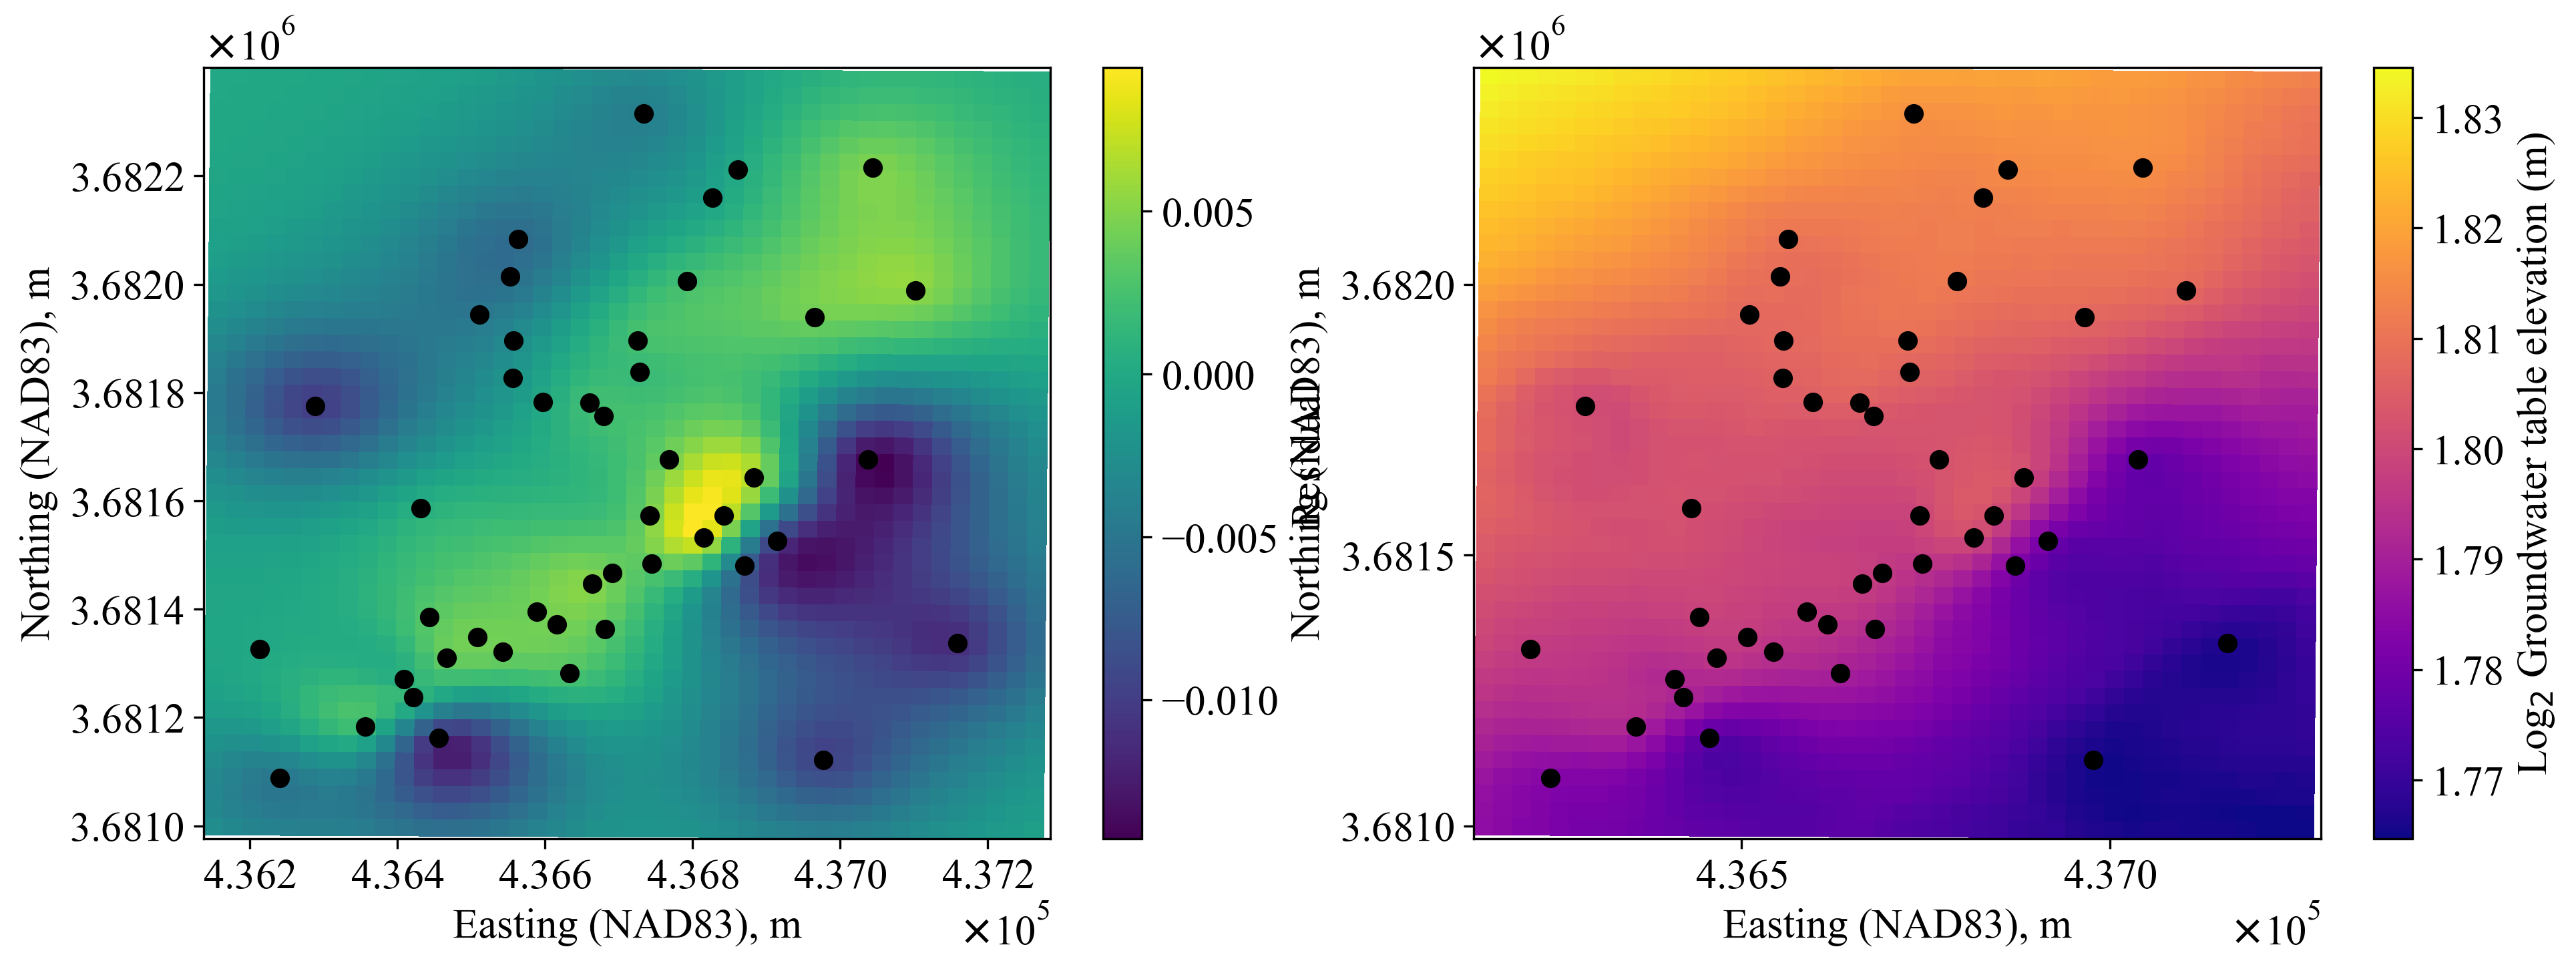

In [75]:
# REMOVE
# Plot all result details
fig, ax = plt.subplots(1,2, figsize=(15,5), dpi=300)
fontsize=15
xx = np.array(XX)

titles = ["Kriging map colored by residuals from\n Regression trend line", str("Linear Regression + Kriging\n Log{} Tritium Reference Field | {}".format('$_{2}$',"Averaged 2011",))]

map_0 = ax[0].pcolor(
    xx[:,0].reshape(x_loc.shape),
    xx[:,1].reshape(x_loc.shape),
    r_map.reshape(x_loc.shape),
)
fig.colorbar(map_0, ax=ax[0]).set_label(label='Residual',size=fontsize)

map_1 = ax[1].pcolor(
    xx[:,0].reshape(x_loc.shape),
    xx[:,1].reshape(x_loc.shape),
    y_map.reshape(x_loc.shape), 
    cmap='plasma',
)
fig.colorbar(map_1, ax=ax[1]).set_label(label="Log{} Groundwater table elevation (m)".format('$_{2}$'), size=fontsize)

colors=['black', 'black']

for i in range(2):
    ax[i].scatter(X.iloc[:,0], X.iloc[:,1], c=colors[i], alpha=1)
    plt.rc('font', size=fontsize)
    # ax[i].set_xticks(fontsize=fontsize)
    ax[i].tick_params(axis='both', which='major', labelsize=fontsize)
    # ax[i].yticks(fontsize=fontsize)
    ax[i].set_xlabel("Easting (NAD83), m", fontsize=fontsize)
    ax[i].set_ylabel("Northing (NAD83), m", fontsize=fontsize)
    # ax[i].set_title(titles[i],y=1.04, fontweight='bold')
    ax[i].ticklabel_format(style='sci', axis='both',scilimits=(-1,1), useMathText=True)

plt.locator_params(axis='x', nbins=4, tight=False)
plt.locator_params(axis='y', nbins=4, tight=False)

fig.show()

In [76]:
X_approx, y_approx = get_approx_predictions(X, y_map, XX)

/var/folders/4f/fztycq7j0wj0t_2bhzck543c0000gp/T/ipykernel_46666/460455892.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_approx.iloc[:,0], X_approx.iloc[:,1], c='red', alpha=1, cmap='plasma') # Approximate point
/var/folders/4f/fztycq7j0wj0t_2bhzck543c0000gp/T/ipykernel_46666/460455892.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


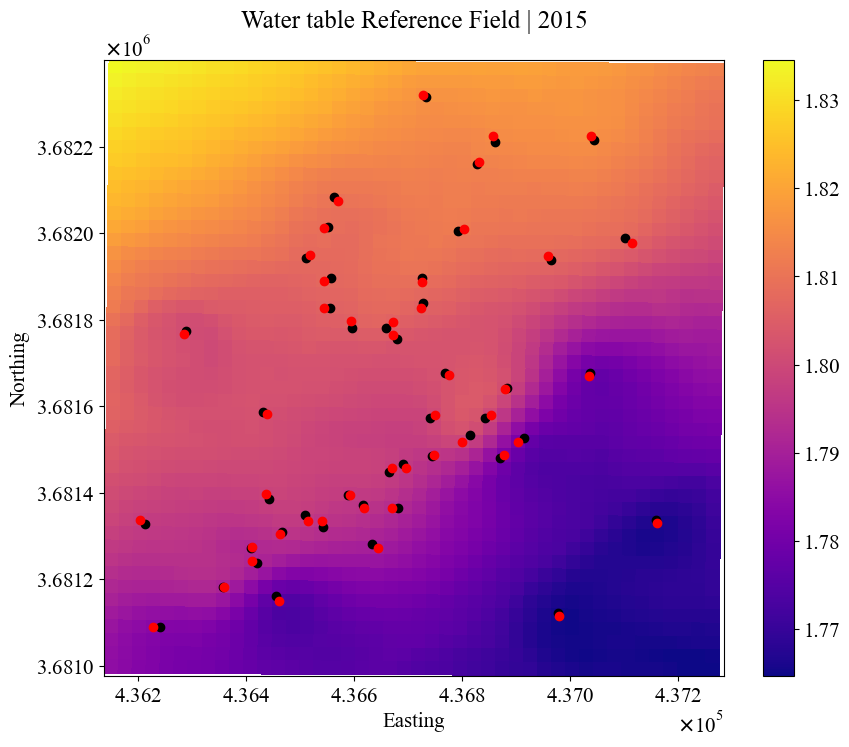

In [77]:
# Plot all result details
fig, ax = plt.subplots(1,1,figsize=(10,8))
xx = np.array(XX)
titles = [str("Water table Reference Field | {}".format(year))]

map_1 = ax.pcolor(
    xx[:,0].reshape(x_loc.shape),
    xx[:,1].reshape(x_loc.shape),
    y_map.reshape(x_loc.shape), 
    cmap='plasma',
)
fig.colorbar(map_1, ax=ax)

ax.scatter(X.iloc[:,0], X.iloc[:,1], c='black', alpha=1) # Real point
ax.scatter(X_approx.iloc[:,0], X_approx.iloc[:,1], c='red', alpha=1, cmap='plasma') # Approximate point

ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
ax.set_title(titles[0],y=1.04)
ax.ticklabel_format(style='sci', axis='both',scilimits=(-1,1), useMathText=True)

fig.show()

MSE LR:  2.6906584454515895e-07
R^2 LR:  0.9980593225651592
[0. 0. 0. 0. 0. 0.]


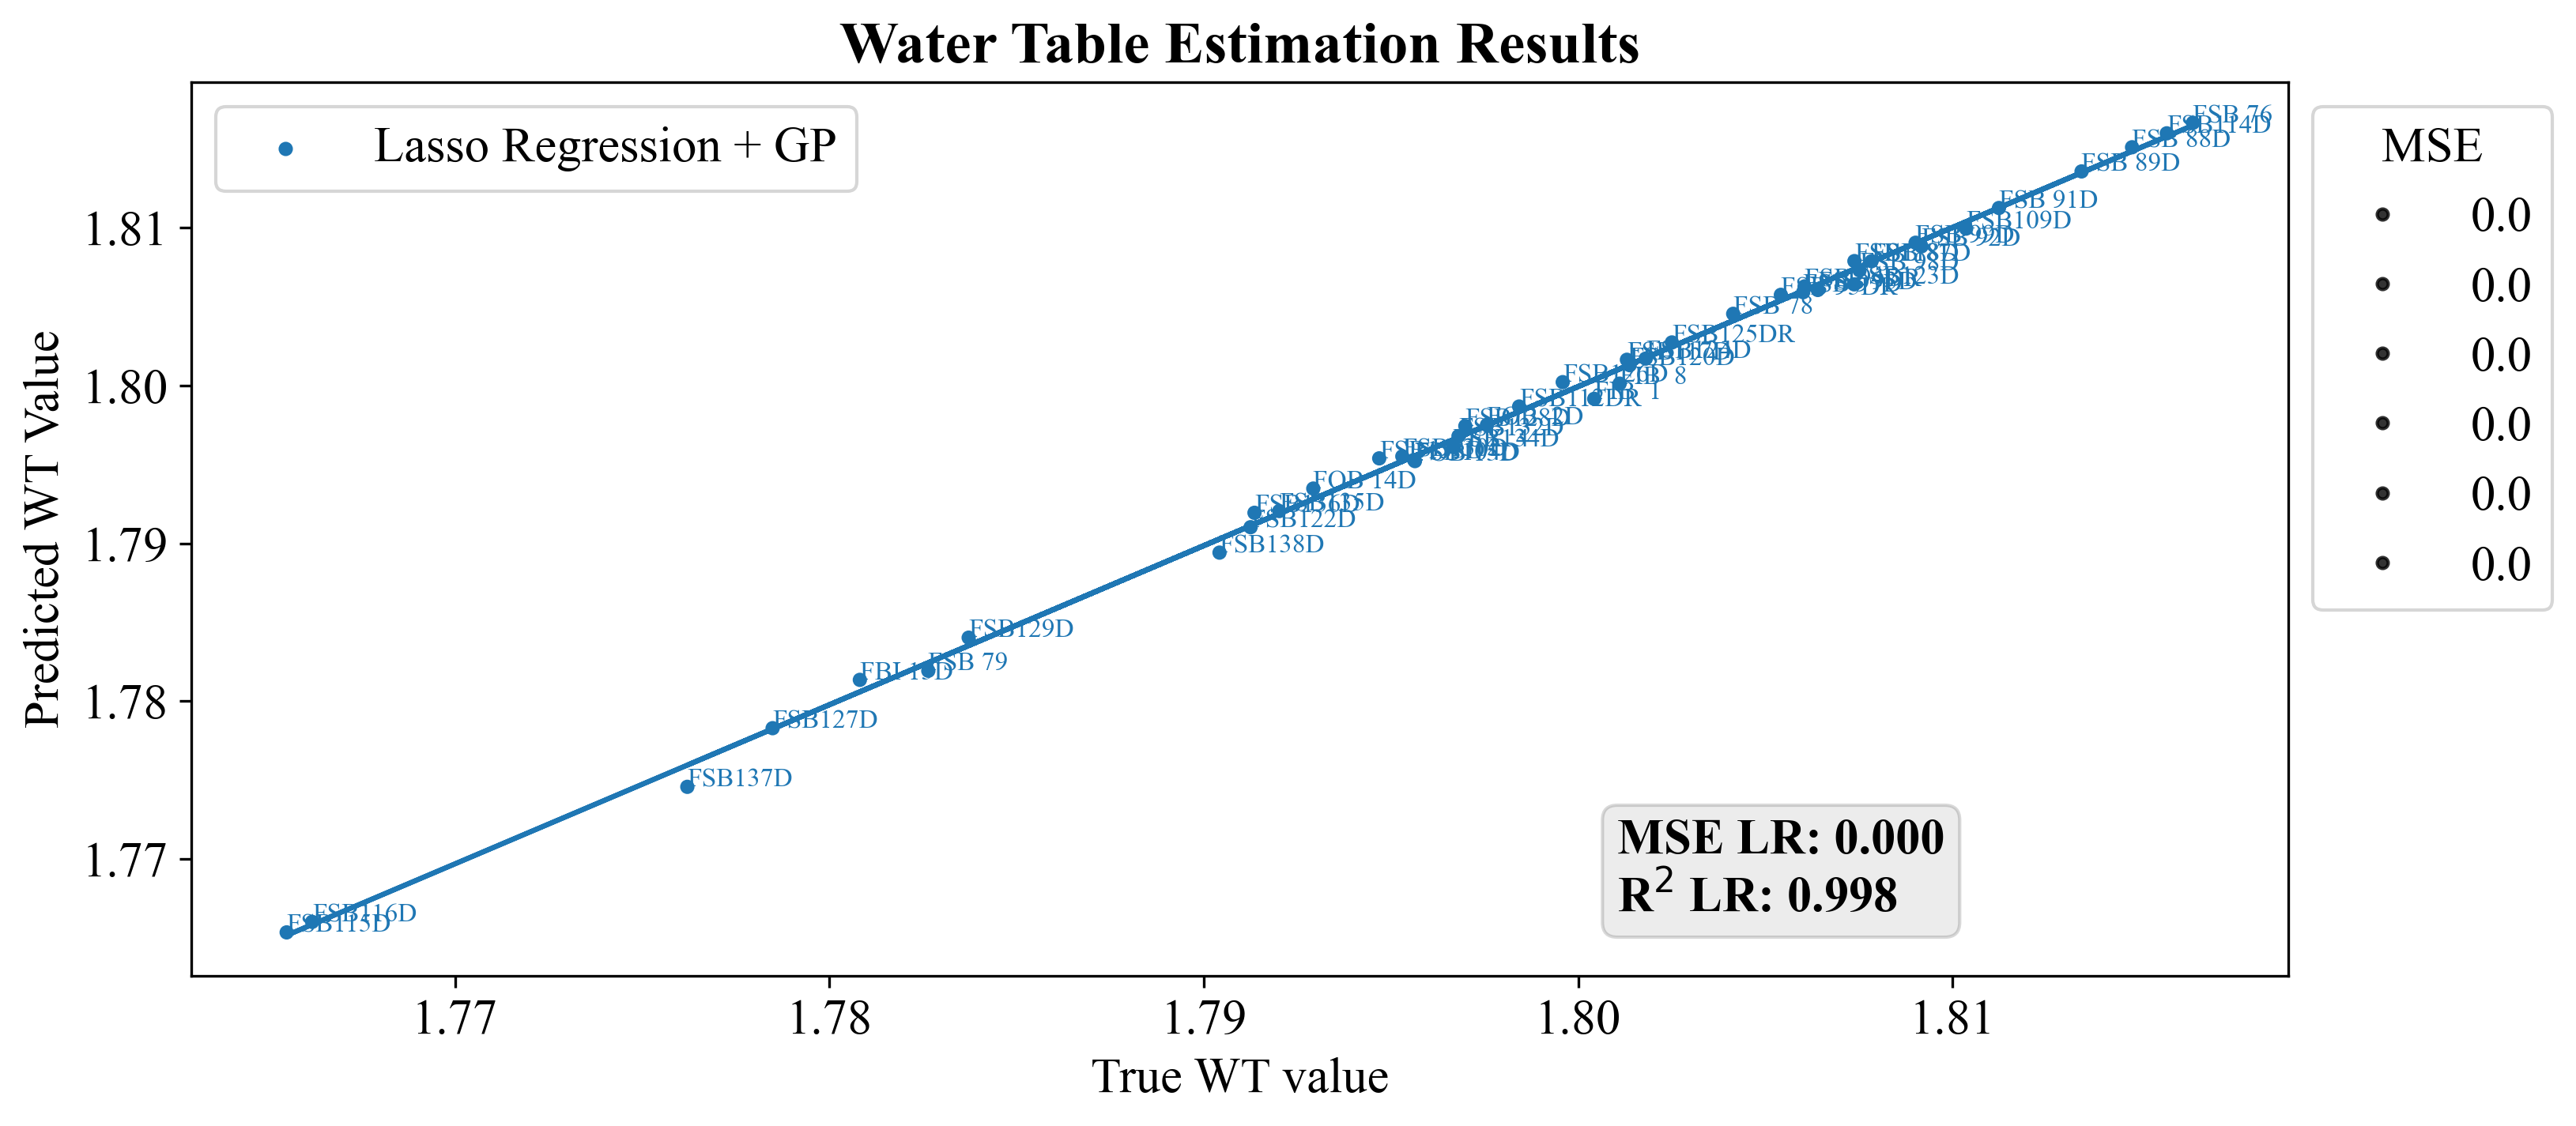

<Figure size 1280x960 with 0 Axes>

In [78]:
fig, ax = plt.subplots(figsize=(10,5),dpi=300)

plt.rcParams["legend.loc"] = 'upper left'
print("MSE LR: ", metrics.mse(y, y_approx))

print("R^2 LR: ",r2_score(y, y_approx))
text = "MSE LR: {:.3f}".format(metrics.mse(y, y_approx)) + "\n" + "R{} LR: {:.3f}".format('$^{2}$', r2_score(y, y_approx))

plt.figure( dpi=200)

ax.set_title('Water Table Estimation Results',fontweight='bold')
ax.set_xlabel('True WT value')
ax.set_ylabel('Predicted WT Value')

err_lr = []
for i in range(len(y)):
    err_lr.append(metrics.mse([y[i]], [y_approx[i]]))

minmaxscaler=MinMaxScaler()
minmaxscaler.fit_transform(np.array(err_lr).reshape(-1,1)).flatten().tolist()

err_lr_s = [(x+5)**1.5 for x in err_lr]
scatter1 = ax.scatter(y, y_approx, label = "Lasso Regression + GP", s=err_lr_s)

props = dict(boxstyle='round', facecolor='grey', alpha=0.15)

fig.tight_layout()

fig.text(0.68, 0.06, text, transform=ax.transAxes, fontsize=15, fontweight='bold', verticalalignment='bottom', bbox=props) #1.025, 0.06

m_lr, b_lr = np.polyfit(y.astype("float64"), np.array(y_approx).flatten(), 1)

legend1 = ax.legend()
ax.add_artist(legend1)
# produce a legend with a cross section of sizes from the scatter
handles, labels = scatter1.legend_elements(prop="sizes", alpha=0.8)
labels=np.round(np.linspace(min(np.array(err_lr).min(),np.array(err_lr).min()), max(np.array(err_lr).max(),np.array(err_lr).max()) ,6),3)
print(labels)

legend2 = ax.legend(handles, labels, title="MSE", bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

for i, txt in enumerate(station_names):
    ax.annotate(txt, (y[i], y_approx[i]), fontsize=8, color='#1f77b4')

ax.plot(y, m_lr*y + b_lr)

## Well optimization

Select initial wells + determine its index number respectively

In [79]:
initial_stations = ['FSB 95DR','FSB130D','FSB 79', 'FSB 97D', 'FSB126D']
station_list = list(wt_interp.columns)

initial_idx = []
for i in initial_stations:
  initial_idx.append(station_list.index(i))

initial_indices = initial_idx.copy()
print(initial_idx)

[17, 38, 9, 18, 34]


Run well selection optimization using:<br>
- y_map_lr as the reference since it gave us the smallest MSE and the best R^2.
- 'FSB 95DR','FSB130D','FSB 79', 'FSB 97D', and 'FSB126D' as the starting wells
- a maximum of 20 wells

In [80]:
from pylenm2.stats import preprocess

import warnings
for msg in WARNING_MESSAGES_TO_IGNORE:
    warnings.filterwarnings(
        "ignore", 
        message=msg,
    )


max_stations = 35
ft=['Easting', 'Northing', 'Elevation', 'Slope']

y_map_las, r_map_las, residuals_las, las_trend = stats_gp.interpolate_topo(
    X, y, XX, ft=ft, regression='lasso', smooth=True,
)

selected_stations_idx, errors = preprocess.get_Best_Stations(
    X=X, 
    y=y, 
    xx=XX, 
    ref=y_map_las, 
    initial=initial_idx, 
    max_stations=max_stations, 
    ft=ft, 
    regression='lasso',
)

Station:   0%|          | 0/30 [00:00<?, ?it/s]/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklear

# of stations to choose from:  41


/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWa

2024-11-04 20:17:47,163 [INFO] preprocess.py: line 239: Selected station: 7 with a MSE error of 8.650655708692325e-05.


/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWa

Selected station: 7 with a MSE error of 8.650655708692325e-05.
# of stations to choose from:  40


/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWa

2024-11-04 20:18:12,884 [INFO] preprocess.py: line 239: Selected station: 30 with a MSE error of 2.8261913680591322e-05.


/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWa

Selected station: 30 with a MSE error of 2.8261913680591322e-05.
# of stations to choose from:  39


/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWa

2024-11-04 20:18:36,214 [INFO] preprocess.py: line 239: Selected station: 36 with a MSE error of 2.64421923144543e-05.


/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
Station:  10%|█         | 3/30 [01:15<11:09, 24.80s/it]/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-pac

Selected station: 36 with a MSE error of 2.64421923144543e-05.
# of stations to choose from:  38


/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWa

2024-11-04 20:18:58,277 [INFO] preprocess.py: line 239: Selected station: 24 with a MSE error of 2.3418300359187248e-05.


/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/sklearn/model_selection/_search.py:979: UserWarning: 

Selected station: 24 with a MSE error of 2.3418300359187248e-05.
# of stations to choose from:  37
2024-11-04 20:19:19,335 [INFO] preprocess.py: line 239: Selected station: 25 with a MSE error of 2.0111855748080874e-05.


Station:  17%|█▋        | 5/30 [01:58<09:29, 22.76s/it]

Selected station: 25 with a MSE error of 2.0111855748080874e-05.
# of stations to choose from:  36
2024-11-04 20:19:41,208 [INFO] preprocess.py: line 239: Selected station: 4 with a MSE error of 1.427613216734399e-05.


Station:  20%|██        | 6/30 [02:20<08:59, 22.46s/it]

Selected station: 4 with a MSE error of 1.427613216734399e-05.
# of stations to choose from:  35
2024-11-04 20:20:04,428 [INFO] preprocess.py: line 239: Selected station: 5 with a MSE error of 1.3779465554237839e-05.


Station:  23%|██▎       | 7/30 [02:43<08:42, 22.71s/it]

Selected station: 5 with a MSE error of 1.3779465554237839e-05.
# of stations to choose from:  34
2024-11-04 20:20:27,437 [INFO] preprocess.py: line 239: Selected station: 0 with a MSE error of 8.940282906587338e-06.


Station:  27%|██▋       | 8/30 [03:06<08:21, 22.80s/it]

Selected station: 0 with a MSE error of 8.940282906587338e-06.
# of stations to choose from:  33
2024-11-04 20:20:52,453 [INFO] preprocess.py: line 239: Selected station: 33 with a MSE error of 8.061358645490118e-06.


Station:  30%|███       | 9/30 [03:31<08:13, 23.50s/it]

Selected station: 33 with a MSE error of 8.061358645490118e-06.
# of stations to choose from:  32
2024-11-04 20:21:15,136 [INFO] preprocess.py: line 239: Selected station: 14 with a MSE error of 7.457158394399817e-06.


Station:  33%|███▎      | 10/30 [03:54<07:44, 23.24s/it]

Selected station: 14 with a MSE error of 7.457158394399817e-06.
# of stations to choose from:  31
2024-11-04 20:21:35,874 [INFO] preprocess.py: line 239: Selected station: 32 with a MSE error of 1.1186144892045947e-05.


Station:  37%|███▋      | 11/30 [04:15<07:07, 22.48s/it]

Selected station: 32 with a MSE error of 1.1186144892045947e-05.
# of stations to choose from:  30
2024-11-04 20:21:56,210 [INFO] preprocess.py: line 239: Selected station: 37 with a MSE error of 1.0021473760723233e-05.


Station:  40%|████      | 12/30 [04:35<06:32, 21.83s/it]

Selected station: 37 with a MSE error of 1.0021473760723233e-05.
# of stations to choose from:  29
2024-11-04 20:22:16,508 [INFO] preprocess.py: line 239: Selected station: 21 with a MSE error of 8.578586380765328e-06.


Station:  43%|████▎     | 13/30 [04:55<06:03, 21.36s/it]

Selected station: 21 with a MSE error of 8.578586380765328e-06.
# of stations to choose from:  28
2024-11-04 20:22:36,420 [INFO] preprocess.py: line 239: Selected station: 10 with a MSE error of 9.110771827093412e-06.


Station:  47%|████▋     | 14/30 [05:15<05:34, 20.92s/it]

Selected station: 10 with a MSE error of 9.110771827093412e-06.
# of stations to choose from:  27
2024-11-04 20:22:57,226 [INFO] preprocess.py: line 239: Selected station: 45 with a MSE error of 7.865011926709222e-06.


Station:  50%|█████     | 15/30 [05:36<05:13, 20.89s/it]

Selected station: 45 with a MSE error of 7.865011926709222e-06.
# of stations to choose from:  26
2024-11-04 20:23:16,797 [INFO] preprocess.py: line 239: Selected station: 43 with a MSE error of 7.688089695836912e-06.


Station:  53%|█████▎    | 16/30 [05:56<04:46, 20.49s/it]

Selected station: 43 with a MSE error of 7.688089695836912e-06.
# of stations to choose from:  25
2024-11-04 20:23:35,073 [INFO] preprocess.py: line 239: Selected station: 23 with a MSE error of 6.443620757692986e-06.


Station:  57%|█████▋    | 17/30 [06:14<04:17, 19.83s/it]

Selected station: 23 with a MSE error of 6.443620757692986e-06.
# of stations to choose from:  24
2024-11-04 20:23:51,497 [INFO] preprocess.py: line 239: Selected station: 19 with a MSE error of 6.287924409871824e-06.


Station:  60%|██████    | 18/30 [06:30<03:45, 18.80s/it]

Selected station: 19 with a MSE error of 6.287924409871824e-06.
# of stations to choose from:  23
2024-11-04 20:24:06,115 [INFO] preprocess.py: line 239: Selected station: 39 with a MSE error of 6.141048171063155e-06.


Station:  63%|██████▎   | 19/30 [06:45<03:13, 17.55s/it]

Selected station: 39 with a MSE error of 6.141048171063155e-06.
# of stations to choose from:  22
2024-11-04 20:24:19,777 [INFO] preprocess.py: line 239: Selected station: 13 with a MSE error of 6.107896657541162e-06.


Station:  67%|██████▋   | 20/30 [06:59<02:43, 16.38s/it]

Selected station: 13 with a MSE error of 6.107896657541162e-06.
# of stations to choose from:  21
2024-11-04 20:24:32,987 [INFO] preprocess.py: line 239: Selected station: 12 with a MSE error of 6.134406962007382e-06.


Station:  70%|███████   | 21/30 [07:12<02:18, 15.43s/it]

Selected station: 12 with a MSE error of 6.134406962007382e-06.
# of stations to choose from:  20
2024-11-04 20:24:45,424 [INFO] preprocess.py: line 239: Selected station: 16 with a MSE error of 6.1057550464923885e-06.


Station:  73%|███████▎  | 22/30 [07:24<01:56, 14.53s/it]

Selected station: 16 with a MSE error of 6.1057550464923885e-06.
# of stations to choose from:  19
2024-11-04 20:24:57,431 [INFO] preprocess.py: line 239: Selected station: 11 with a MSE error of 6.442182908573621e-06.


Station:  77%|███████▋  | 23/30 [07:36<01:36, 13.77s/it]

Selected station: 11 with a MSE error of 6.442182908573621e-06.
# of stations to choose from:  18
2024-11-04 20:25:08,542 [INFO] preprocess.py: line 239: Selected station: 41 with a MSE error of 6.4515245097846336e-06.


Station:  80%|████████  | 24/30 [07:47<01:17, 12.97s/it]

Selected station: 41 with a MSE error of 6.4515245097846336e-06.
# of stations to choose from:  17
2024-11-04 20:25:19,105 [INFO] preprocess.py: line 239: Selected station: 6 with a MSE error of 6.442494333120726e-06.


Station:  83%|████████▎ | 25/30 [07:58<01:01, 12.25s/it]

Selected station: 6 with a MSE error of 6.442494333120726e-06.
# of stations to choose from:  16
2024-11-04 20:25:29,599 [INFO] preprocess.py: line 239: Selected station: 29 with a MSE error of 6.664075591914579e-06.


Station:  87%|████████▋ | 26/30 [08:08<00:46, 11.72s/it]

Selected station: 29 with a MSE error of 6.664075591914579e-06.
# of stations to choose from:  15
2024-11-04 20:25:38,952 [INFO] preprocess.py: line 239: Selected station: 8 with a MSE error of 6.386102526962009e-06.


Station:  90%|█████████ | 27/30 [08:18<00:33, 11.01s/it]

Selected station: 8 with a MSE error of 6.386102526962009e-06.
# of stations to choose from:  14
2024-11-04 20:25:47,079 [INFO] preprocess.py: line 239: Selected station: 15 with a MSE error of 6.219336664411457e-06.


Station:  93%|█████████▎| 28/30 [08:26<00:20, 10.15s/it]

Selected station: 15 with a MSE error of 6.219336664411457e-06.
# of stations to choose from:  13
2024-11-04 20:25:54,991 [INFO] preprocess.py: line 239: Selected station: 40 with a MSE error of 6.250507077132286e-06.


Station:  97%|█████████▋| 29/30 [08:34<00:09,  9.48s/it]

Selected station: 40 with a MSE error of 6.250507077132286e-06.
# of stations to choose from:  12
2024-11-04 20:26:02,526 [INFO] preprocess.py: line 239: Selected station: 1 with a MSE error of 6.371025854864161e-06.


Station: 100%|██████████| 30/30 [08:41<00:00, 17.40s/it]

Selected station: 1 with a MSE error of 6.371025854864161e-06.
2024-11-04 20:26:02,527 [INFO] preprocess.py: line 335: selected = [17, 38, 9, 18, 34, 7, 30, 36, 24, 25, 4, 5, 0, 33, 14, 32, 37, 21, 10, 45, 43, 23, 19, 39, 13, 12, 16, 11, 41, 6, 29, 8, 15, 40, 1]


Text(0, 0.5, 'Error (MSE)')

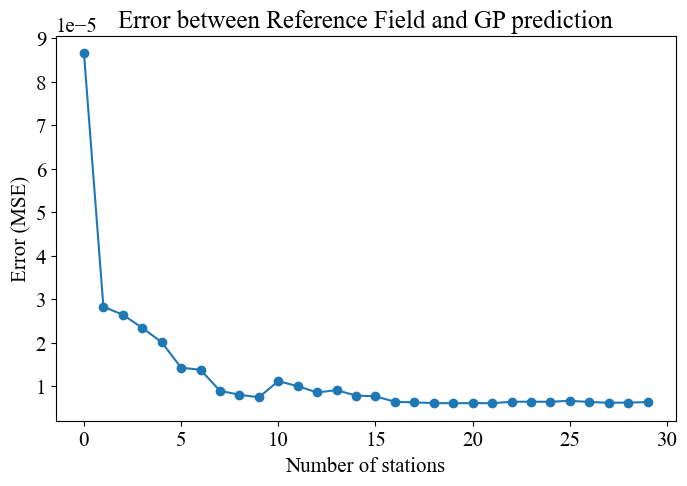

In [81]:
plt.figure(figsize=(8,5), dpi=100)
plt.plot(pd.Series(errors[0:31]), marker='o')
plt.title('Error between Reference Field and GP prediction')
plt.xlabel('Number of stations')
plt.ylabel('Error (MSE)')

In [82]:
import warnings
for msg in WARNING_MESSAGES_TO_IGNORE:
    warnings.filterwarnings(
        "ignore", 
        message=msg,
    )

# Interpolate using selected stations 
ft=['Easting', 'Northing', 'Elevation', 'Slope']
pred_map, r_map, residuals, lr_trend = stats_gp.interpolate_topo(
    X.iloc[selected_stations_idx], 
    y[selected_stations_idx], 
    XX, 
    ft=ft, 
    regression='lasso', 
    smooth=True,
)

In [83]:
import matplotlib.patheffects as path_effects


def plotres_hor(pred_map, selected, nu_stations):
    fontsize = 15
    plt.rcParams["legend.loc"] = 'upper right'

    fig, ax = plt.subplots(1,2, figsize=(12,5), dpi=200)

    xx = np.array(XX)
    titles = [str("Water table Reference Field | {}".format("Averaged 2005")), str('GP Prediction | {} | Stations: {}'.format("Averaged 2005", nu_stations))]

    map_1 = ax[0].pcolor(xx[:,0].reshape(x_loc.shape),
                    xx[:,1].reshape(x_loc.shape),
                    pred_map.reshape(x_loc.shape),
                    cmap='plasma',
                    vmin=y_map.min(), vmax=y_map.max())
    ax[0].scatter(X.iloc[:,0], X.iloc[:,1], c='black', alpha=0.2)
    ax[0].scatter(X.iloc[selected[0:5],0], X.iloc[selected[0:5],1], c='red', alpha=1, label='Initial stations [1-5]')
    ax[0].scatter(X.iloc[selected[5:13],0], X.iloc[selected[5:13],1], c='limegreen', alpha=1, label='Selected stations [6-13]')
    ax[0].scatter(X.iloc[selected[13:22],0], X.iloc[selected[13:22],1], c='yellow', alpha=1, label='Selected stations [14-22]')
    ax[0].scatter(X.iloc[selected[22:30],0], X.iloc[selected[22:30],1], c='blue', alpha=1, label='Selected stations [23-30]')
    ax[0].legend(bbox_to_anchor=(1.05, 1.45))
    fig.colorbar(map_1, ax=ax[0]).set_label(label="Log{} Groundwater table elevation (m)".format('$_{2}$'), size=fontsize)

    for i in range(2):
        ax[i].set_xlabel("Easting (NAD83), m", fontsize=fontsize)
        ax[i].set_ylabel("Northing (NAD83), m", fontsize=fontsize)
        plt.rc('font', size=fontsize)
        ax[i].tick_params(axis='both', which='major', labelsize=fontsize)
        ax[i].locator_params(axis='both', nbins=4, tight=True)

    ax[0].ticklabel_format(style='sci', axis='both',scilimits=(-1,1), useMathText=True)
    ax[1].ticklabel_format(style='sci', axis='y',scilimits=(-1,1), useMathText=True)
    ax[1].set_xlim([-1, 31])
    ax[1].set_ylim([0, 9e-05])

    for i in range(nu_stations):
        if(i<=4): c='r'
        elif(i>4 and i<=12): c='limegreen'
        elif(i>12 and i<=21): c='yellow'
        else: c='b'

        if(i!=nu_stations-1):
            ax[1].plot(range(1,31)[i:i+2],pd.Series(errors[0:31])[i:i+2], color=c, zorder=1)#,path_effects=[path_effects.SimpleLineShadow(),path_effects.Normal()])

        ax[1].scatter(range(1,31)[i],pd.Series(errors[0:31])[i], marker='o', color=c, zorder=2,path_effects=[path_effects.SimplePatchShadow(offset=(1, -2.5)),path_effects.Normal()])

    ax[1].axhspan(0,10,facecolor='gray', alpha=0.3)
    ax[1].grid(True, alpha=0.4)
    ax[1].set_xlabel('Number of stations')
    ax[1].set_ylabel('Error (MSE)')

    fig.show()

/var/folders/4f/fztycq7j0wj0t_2bhzck543c0000gp/T/ipykernel_46666/1108298829.py:54: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


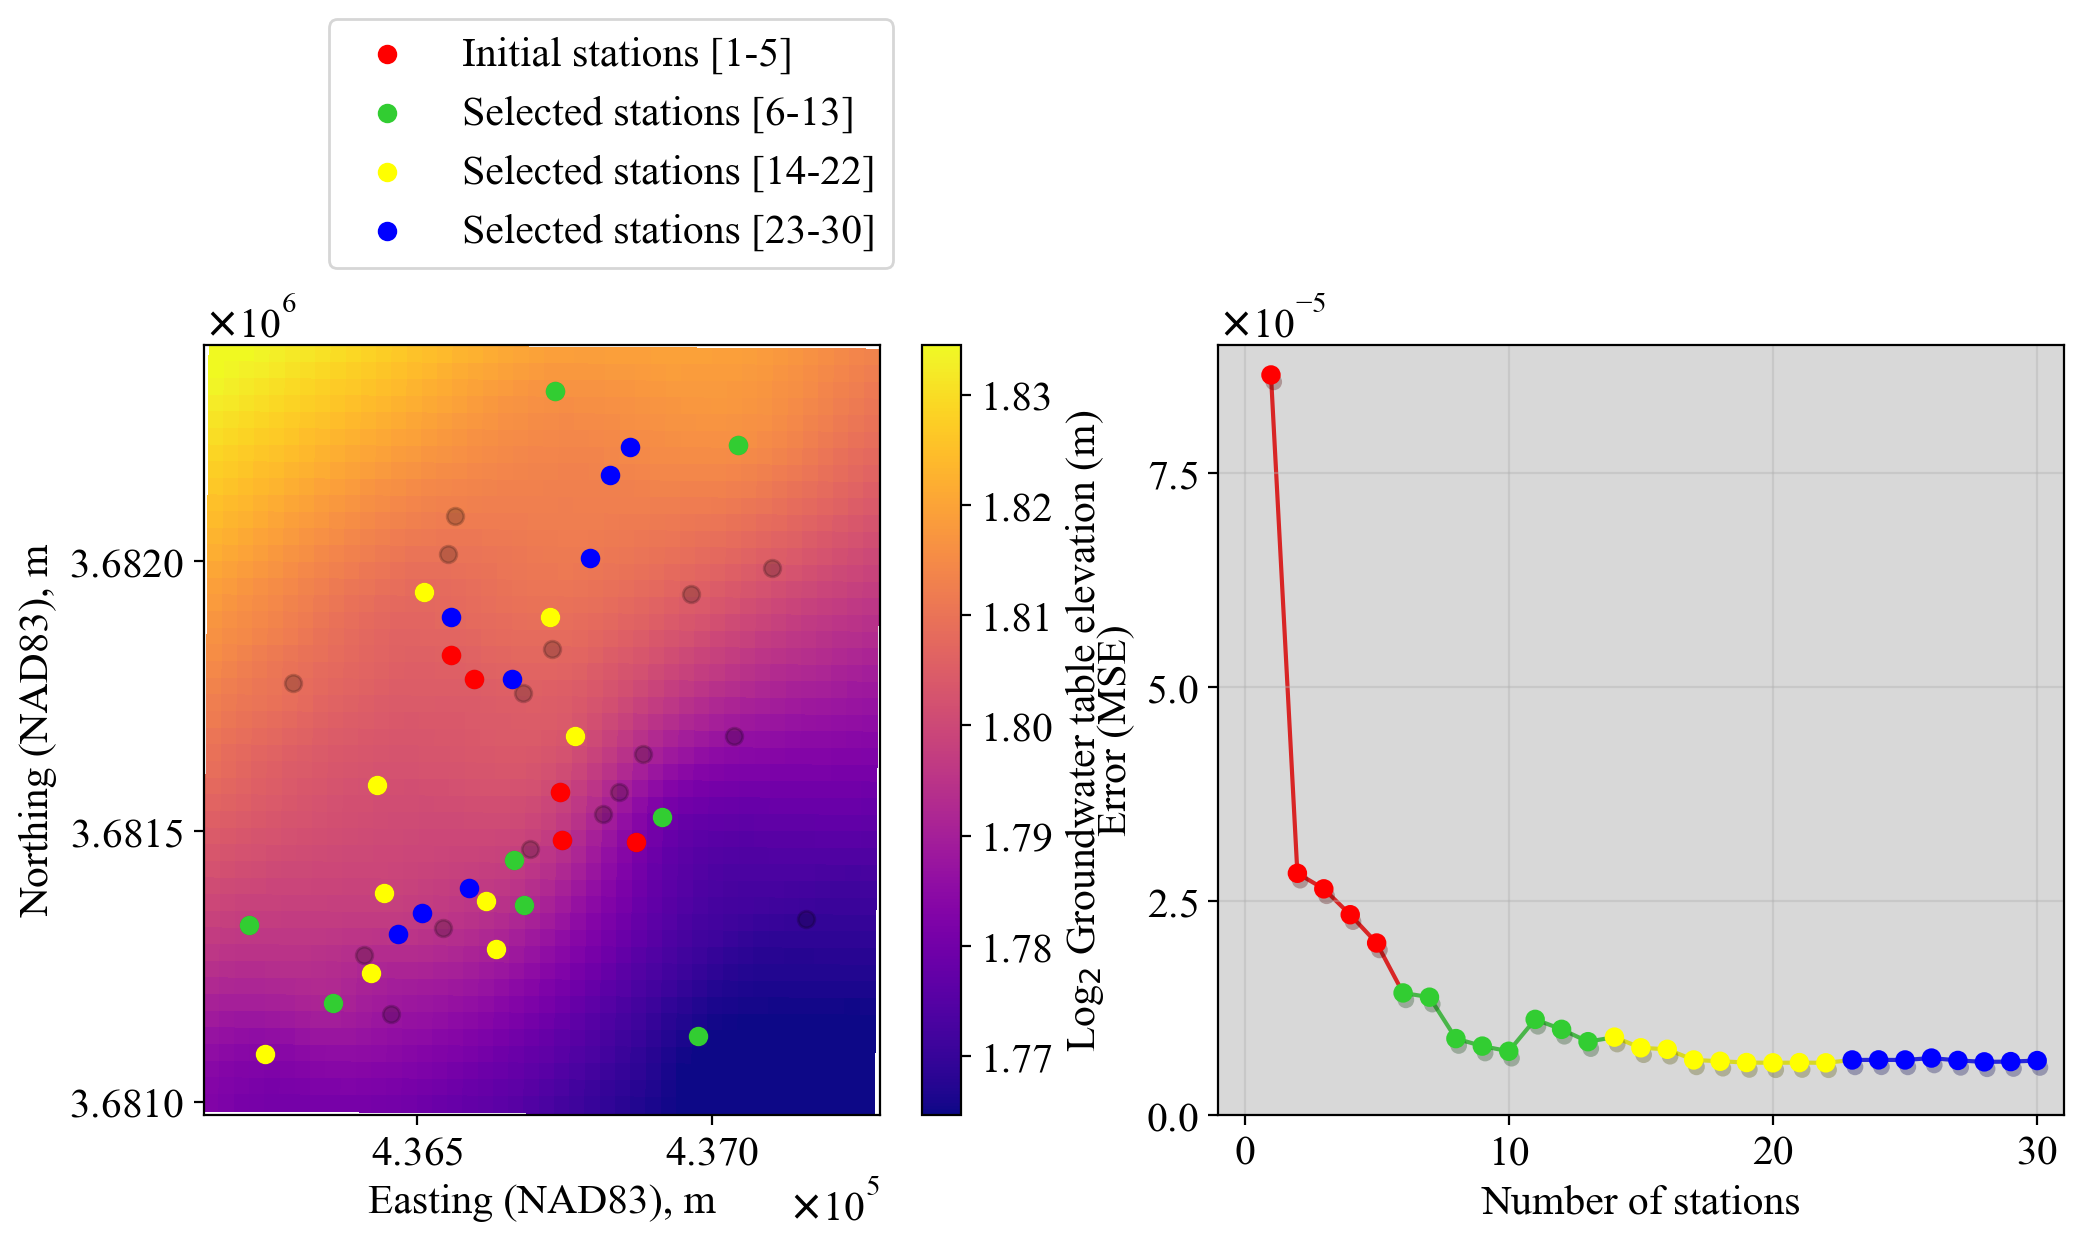

In [84]:
import warnings
for msg in WARNING_MESSAGES_TO_IGNORE:
    warnings.filterwarnings(
        "ignore", 
        message=msg,
    )

selected = selected_stations_idx[0:30]
nu_stations = len(selected)
pred_map, r_map, residuals, lr_trend = stats_gp.interpolate_topo(
    X.iloc[selected], 
    y[selected], 
    XX, 
    ft=ft, 
    regression='lasso', 
    smooth=True)

plotres_hor(
    pred_map,
    selected, 
    nu_stations,
)